In [1]:
import pandas as pd
import os
import numpy as np


In [2]:
customer = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/customer.csv")
print(customer.head())
print("*****\n")

# Check for missing values in each column
print("Missing values per column:")
print(customer.isnull().sum())
print("*****\n")

print("Value counts for 'DISTRIBUTION_MODE_DESCRIPTION':")
print(customer['DISTRIBUTION_MODE_DESCRIPTION'].value_counts(dropna=False))
print("*****\n")

customer_clean = customer.copy()
# Fill missing values in 'DISTRIBUTION_MODE_DESCRIPTION' with 'OFS'
customer_clean['DISTRIBUTION_MODE_DESCRIPTION'] = customer_clean['DISTRIBUTION_MODE_DESCRIPTION'].fillna('OFS')
# Rename 'CUSTOMER_NUMBER' to 'CUSTOMER_ID' 
customer_clean = customer_clean.rename(columns={'CUSTOMER_NUMBER': 'CUSTOMER_ID'})
# Display the first few rows of the cleaned dataset
print("*****\n")
print("First 5 rows of the cleaned customer dataset (customer_clean):")
print(customer_clean.head())

  SALES_OFFICE  CUSTOMER_NUMBER SALES_OFFICE_DESCRIPTION  \
0         G111        500964906               Draper, UT   
1         G111        501543906               Draper, UT   
2         G293        501394111               Tacoma, WA   
3         G238        501528559     Colorado Springs, CO   
4         G132        500504789              Alamosa, CO   

  DISTRIBUTION_MODE_DESCRIPTION SHIPPING_CONDITIONS_DESCRIPTION  \
0                      Sideload                        48 Hours   
1                      Sideload                        48 Hours   
2                           OFS                        24 Hours   
3                           OFS                        48 Hours   
4                           OFS                        48 Hours   

  COLD_DRINK_CHANNEL_DESCRIPTION CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION  
0                     Restaurant                                 Dining  
1                     Restaurant                      Mexican Fast Food  
2             

In [3]:
visit = pd.read_csv(r"C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/visit_plan.csv", low_memory=False)
visit['ANCHOR_DATE'] = pd.to_datetime(visit['ANCHOR_DATE'], errors='coerce')

REAL_MIN_DATE = pd.Timestamp("2024-06-05")   
REAL_MAX_DATE = pd.Timestamp("2025-05-26")   

# Filter visit data
visit_valid = visit[
    (visit["ANCHOR_DATE"] >= REAL_MIN_DATE) &
    (visit["ANCHOR_DATE"] <= REAL_MAX_DATE)
].copy()


In [4]:
visit_valid_clean = visit_valid.copy()
# Add day of week
visit_valid_clean['WEEK_DAY_OF_ANCHOR_DATE'] = visit_valid_clean['ANCHOR_DATE'].dt.day_name()

# Clean and standardize FREQUENCY column
visit_valid_clean['FREQUENCY'] = visit_valid_clean['FREQUENCY'].astype(str).str.strip()

# Apply mapping to standardize frequency values
freq_mapping = {
    "01": 1, "1": 1, "1.0": 1, "1 ": 1, " 1": 1, "Every Week On": 1,
    "02": 2, "2": 2, "2.0": 2, "2 ": 2, "Every Second Week On": 2,
    "03": 3, "3": 3, "3.0": 3, "3 ": 3, "Every Third Week On": 3,
    "04": 4, "4": 4, "4.0": 4, "4 ": 4, "Every Fourth Week On": 4,
    "05": 5, "5": 5, "5.0": 5, "5 ": 5, "Every Fifth Week On": 5,
    "06": 6, "6": 6, "6.0": 6, "Every Sixth Week On": 6,
    "08": 8, "8": 8, "8.0": 8, "Every Eighth Week On": 8,
    "10": 10, "10.0": 10, "Every Tenth Week On": 10,
    "Not Applicable": None
}

# Map and convert to numeric
visit_valid_clean['FREQUENCY_NUM'] = visit_valid_clean['FREQUENCY'].replace(freq_mapping)
visit_valid_clean['FREQUENCY_NUM'] = pd.to_numeric(visit_valid_clean['FREQUENCY_NUM'], errors='coerce').astype('Int64')

# Convert to days (weeks * 7)
visit_valid_clean['WINDOW_FREQUENCY'] = visit_valid_clean['FREQUENCY_NUM'] * 7

visit_valid_clean['DISTRIBUTION_MODE'].value_counts()
code_to_description = {
    'OF': 'OFS',
    'SL': 'Sideload',
    'BK': 'Bulk Distribution',
    'FS': 'Full Service',
    'RD': 'Rapid Delivery',
    'NR': 'Night Rapid Delivery',
    'NS': 'Tell Sell',
    'NO': 'Night OFS',
    'EZ': 'E Pallet',
    'SE': 'Special Events',
    'DD': 'Night Sideload'
}
# creating distribution_mode_desc column
visit_valid_clean['DISTRIBUTION_MODE_DESC'] = visit_valid_clean['DISTRIBUTION_MODE'].map(code_to_description)
visit_valid_clean['DISTRIBUTION_MODE_DESC'].value_counts()
visit_valid_clean.rename(columns = {'SALES_OFFICE':'PLANT_ID'}, inplace= True)
# Compute NEXT_ANCHOR_DATE from the LATEST anchor + frequency
visit_window = visit_valid_clean.copy()  
visit_window['NEXT_ANCHOR_DATE'] = (
    visit_window['ANCHOR_DATE'] + 
    pd.to_timedelta(visit_window['WINDOW_FREQUENCY'], unit='D')
)

#format anchor date
#visit_window["ANCHOR_DATE"] = pd.to_datetime(visit_window["ANCHOR_DATE"], errors="coerce").dt.tz_localize(None)
# Clean up columns, dropping columns unnecessary to find cart abadonment, skip when modelling 
visit_window.drop(columns=["FREQUENCY", "DISTRIBUTION_MODE"])

print(visit_window.head())
print(visit_window.shape)

# Group by CUSTOMER_ID and check if all FREQUENCY values are the same
freq_consistency = (
    visit_window
    .groupby("CUSTOMER_ID")["FREQUENCY"]
    .nunique()  # number of unique frequencies per customer
)

# Customers with more than 1 unique frequency → inconsistent
inconsistent_customers = freq_consistency[freq_consistency > 1].index.tolist()

print(f"Total customers: {visit_window['CUSTOMER_ID'].nunique()}")
print(f"Customers with inconsistent frequency: {len(inconsistent_customers)}")

C:\Users\91744\AppData\Local\Temp\ipykernel_22348\3015010466.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  visit_valid_clean['FREQUENCY_NUM'] = visit_valid_clean['FREQUENCY'].replace(freq_mapping)


         CUSTOMER_ID FREQUENCY                    ELT_TS SNAPSHOT_DATE  \
831439     501641154        01  2024-04-21T15:58:19.647Z    2024-04-21   
995007     501641154        01  2024-04-20T04:22:24.769Z    2024-04-19   
1048357    501641154        01  2024-04-29T01:32:36.493Z    2024-04-28   
1061951    501641154        01  2024-05-08T01:57:59.678Z    2024-05-07   
1064468    501648556        01  2024-05-10T02:00:22.939Z    2024-05-09   

        ANCHOR_DATE PLANT_ID SALES_OFFICE_DESC DISTRIBUTION_MODE  \
831439   2024-07-10     G262      Glendale, AZ                RD   
995007   2024-07-10     G262      Glendale, AZ                RD   
1048357  2024-07-10     G262      Glendale, AZ                RD   
1061951  2024-07-10     G262      Glendale, AZ                RD   
1064468  2024-06-12     G291      Bellevue, WA                OF   

        SHIPPING_CONDITIONS_DESC WEEK_DAY_OF_ANCHOR_DATE  FREQUENCY_NUM  \
831439                  48 Hours               Wednesday              1

In [5]:
cutoff = pd.read_csv(r"C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/cutoff_times.csv")
print(cutoff.shape)
cutoff = cutoff[~cutoff['PLANT_ID'].isin(['G165'])]
cutoff_clean = cutoff.copy()

# Rename columns
cutoff_clean = cutoff_clean.rename(columns={
    'DISTRIBUTION_MODE': 'DISTRIBUTION_MODE_DESC',
    'SALES_OFFICE': 'SALES_OFFICE_DESCRIPTION',
})


# Remove invalid rows where PLANT_ID == '0'
print("Removing rows where PLANT_ID == '0' (invalid entries)...")
cutoff_clean = cutoff_clean[cutoff_clean['PLANT_ID'].astype(str) != '0']

# Fill missing cutoff times
cutoff_clean["CUTOFFTIME__C"] = cutoff_clean["CUTOFFTIME__C"].fillna("5:00:00 PM")

# Convert cutoff times to 24-hour format
cutoff_clean["CUTOFF_TIME_24H"] = pd.to_datetime(
    cutoff_clean["CUTOFFTIME__C"],
    format="%I:%M:%S %p",
    errors="coerce"
).dt.strftime("%H:%M:%S")

# Drop original column
cutoff_clean.drop(columns=['CUTOFFTIME__C'], inplace=True)
cutoff_clean = cutoff_clean.drop_duplicates(subset='PLANT_ID')
print(cutoff_clean.head())
print(cutoff_clean.shape)


(220, 5)
Removing rows where PLANT_ID == '0' (invalid entries)...
   SALES_OFFICE_DESCRIPTION PLANT_ID SHIPPING_CONDITION_TIME  \
0                Draper, UT     G111                   72hrs   
7                 Logan, UT     G113                   24hrs   
13            Richfield, UT     G115                   24hrs   
21                Price, UT     G116                   24hrs   
23                Ogden, UT     G121                   24hrs   

   DISTRIBUTION_MODE_DESC CUTOFF_TIME_24H  
0               Tell Sell        18:00:00  
7                     OFS        13:00:00  
13               Sideload        15:00:00  
21                    OFS        12:00:00  
23           Full Service        10:00:00  
(41, 5)


In [8]:
order = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/orders.csv")
# Check for missing values
null_counts = order.isnull().sum()
print(null_counts)

# Remove 4 invalid rows where plant_id = 0
print("Removing rows where PLANT_ID == '0' (invalid entries)...")
order_clean = order[order['PLANT_ID'] != '0']


# Convert date columns to datetime
order_clean["CREATED_DATE_UTC"] = pd.to_datetime(order_clean["CREATED_DATE_UTC"], utc=True) ##converts from string to pd.datetime format and makes sure its in utc format
order_clean["CREATED_DATE_UTC"] = order_clean["CREATED_DATE_UTC"].dt.tz_localize(None) #strips timezone order_clean.drop(columns=['CREATED_DATE_EST', 'PLANT_ID', 'MATERIAL_ID']
# Display date range for CREATED_DATE_UTC
min_date = order_clean['CREATED_DATE_UTC'].min()
max_date = order_clean['CREATED_DATE_UTC'].max()
print(f"📅 Date range (UTC): {min_date} to {max_date}")
print("******************\n")

order_clean = order_clean.drop(columns=['CREATED_DATE_EST', 'MATERIAL_ID', 'PLANT_ID'])
# Check for outliers in ORDER_QUANTITY
print("Descriptive statistics for 'ORDER_QUANTITY':")
order_qty_stats = order_clean['ORDER_QUANTITY'].describe()
print(order_qty_stats)
print(order_clean.head())
print(order_clean['CUSTOMER_ID'].nunique()) 
order_clean.to_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/order_clean.csv", index=False)


CUSTOMER_ID           0
CREATED_DATE_EST      0
CREATED_DATE_UTC      0
MATERIAL_ID         195
ORDER_QUANTITY        0
ORDER_TYPE            0
PLANT_ID             11
dtype: int64
Removing rows where PLANT_ID == '0' (invalid entries)...
📅 Date range (UTC): 2024-05-31 05:03:00 to 2025-05-26 04:36:04
******************

Descriptive statistics for 'ORDER_QUANTITY':
count    1.662157e+06
mean     2.810771e+00
std      1.293721e+01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+03
Name: ORDER_QUANTITY, dtype: float64
   CUSTOMER_ID    CREATED_DATE_UTC  ORDER_QUANTITY   ORDER_TYPE
0    600265510 2025-01-10 22:40:25             1.0  CALL CENTER
1    600584506 2024-11-22 17:34:30             1.0    SALES REP
2    600686120 2024-06-05 00:29:33             1.0    SALES REP
3    501087671 2024-12-03 18:14:23             2.0    SALES REP
4    501680332 2025-03-31 22:33:07             1.0    SALES REP
6166


In [9]:
ga = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/google_analytics.csv")
# Check for missing values
null_counts = ga.isnull().sum()
print(null_counts)

# Inspect EVENT_PAGE_TITLE vs EVENT_PAGE_NAME (often redundant)
print(ga[['EVENT_PAGE_TITLE', 'EVENT_PAGE_NAME']].head())
print("******************\n")

ga_clean = ga.copy()

# Handle missing values in DEVICE_MOBILE_BRAND_NAME
print("Top mobile brands (before cleaning):")
print(ga_clean['DEVICE_MOBILE_BRAND_NAME'].value_counts(dropna=False).head(10))
print("******************\n")

# Fill missing brand names with 'Unknown'
ga_clean['DEVICE_MOBILE_BRAND_NAME'] = ga_clean['DEVICE_MOBILE_BRAND_NAME'].fillna('Unknown')
print(ga_clean['DEVICE_MOBILE_BRAND_NAME'].value_counts().head(10))
print("******************\n")

# Drop redundant page columns
print("Dropping redundant columns: 'EVENT_PAGE_TITLE', 'EVENT_PAGE_NAME'")
ga_clean = ga_clean.drop(columns=['EVENT_PAGE_TITLE', 'EVENT_PAGE_NAME'])

CUSTOMER_ID                       0
EVENT_DATE                        0
EVENT_TIMESTAMP                   0
EVENT_NAME                        0
DEVICE_CATEGORY                   0
DEVICE_MOBILE_BRAND_NAME      39468
DEVICE_OPERATING_SYSTEM           0
EVENT_PAGE_NAME             1002510
EVENT_PAGE_TITLE             318091
ITEMS                             0
dtype: int64
         EVENT_PAGE_TITLE                   EVENT_PAGE_NAME
0                     NaN                      Product List
1                  Search                               NaN
2                   Order  MyCoke Orders - Purchase Success
3                     NaN                               NaN
4  Category: All Products                     MyCoke Orders
******************

Top mobile brands (before cleaning):
DEVICE_MOBILE_BRAND_NAME
Google            1600687
Apple              938260
Microsoft          925093
Samsung            126443
Mozilla             54591
NaN                 39468
Motorola             7459
Ope

In [10]:
ga_w_customer = pd.merge(customer_clean.reset_index(drop=True),
                         ga_clean.reset_index(drop=True),
                         on='CUSTOMER_ID',
                         how='inner')
ga_customer= ga_w_customer.copy()

print(ga_customer['CUSTOMER_ID'].nunique())
print(ga_customer.shape)
ga_customer_clean = ga_customer.drop_duplicates()
print(ga_customer_clean.isna().sum())
print(ga_customer_clean.shape)

ga_w_customer.to_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/ga_w_customer.csv", index=False)


6334
(3704088, 14)
SALES_OFFICE                              0
CUSTOMER_ID                               0
SALES_OFFICE_DESCRIPTION                  0
DISTRIBUTION_MODE_DESCRIPTION             0
SHIPPING_CONDITIONS_DESCRIPTION           0
COLD_DRINK_CHANNEL_DESCRIPTION            0
CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION    0
EVENT_DATE                                0
EVENT_TIMESTAMP                           0
EVENT_NAME                                0
DEVICE_CATEGORY                           0
DEVICE_MOBILE_BRAND_NAME                  0
DEVICE_OPERATING_SYSTEM                   0
ITEMS                                     0
dtype: int64
(2942817, 14)


In [11]:
visit_w_cutoff = pd.merge(
    visit_window.reset_index(drop=True),
    cutoff_clean.reset_index(drop=True),
    on="PLANT_ID",
    how="left"
)
visit_w_cutoff["CUTOFF_TIME_24H"] = visit_w_cutoff["CUTOFF_TIME_24H"].fillna("17:00:00")

#combine date + time into datetime
def add_time_to_date(date_series, time_series):
    # Format date as "YYYY-MM-DD", then add time
    dt_str = date_series.dt.strftime("%Y-%m-%d") + " " + time_series
    print(date_series.dt.strftime("%Y-%m-%d").isna().value_counts())
    return pd.to_datetime(dt_str, format="%Y-%m-%d %H:%M:%S")

# Create cutoff datetimes
visit_w_cutoff["ANCHOR_CUTOFF"] = add_time_to_date(
    visit_w_cutoff["ANCHOR_DATE"],
    visit_w_cutoff["CUTOFF_TIME_24H"]
)

visit_w_cutoff["NEXT_ANCHOR_CUTOFF"] = add_time_to_date(
    visit_w_cutoff["NEXT_ANCHOR_DATE"],
    visit_w_cutoff["CUTOFF_TIME_24H"]
)
visit_w_cutoff.drop(columns=['ANCHOR_DATE','NEXT_ANCHOR_DATE', 'DISTRIBUTION_MODE_DESC_x', 'DISTRIBUTION_MODE','FREQUENCY_NUM', 'FREQUENCY', 'ELT_TS','SNAPSHOT_DATE'], inplace=True)
visit_w_cutoff.rename(columns={'DISTRIBUTION_MODE_DESC_y': 'DISTRIBUTION_MODE_DESC'})

visit_cutoff_clean = visit_w_cutoff.copy()
visit_cutoff_clean = visit_w_cutoff.drop_duplicates()
print(visit_cutoff_clean.shape)
print(visit_cutoff_clean.isna().sum())
print(visit_cutoff_clean['CUSTOMER_ID'].nunique())
visit_w_cutoff.to_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/visit_w_cutoff.csv", index=False)

ANCHOR_DATE
False    1797245
Name: count, dtype: int64
NEXT_ANCHOR_DATE
False    1797245
Name: count, dtype: int64
(11697, 12)
CUSTOMER_ID                   0
PLANT_ID                      0
SALES_OFFICE_DESC             0
SHIPPING_CONDITIONS_DESC      0
WEEK_DAY_OF_ANCHOR_DATE       0
WINDOW_FREQUENCY              0
SALES_OFFICE_DESCRIPTION    337
SHIPPING_CONDITION_TIME     337
DISTRIBUTION_MODE_DESC_y    337
CUTOFF_TIME_24H               0
ANCHOR_CUTOFF                 0
NEXT_ANCHOR_CUTOFF            0
dtype: int64
6131


In [12]:
material = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/material.csv")
print(material.shape)

material_clean = material.copy()
# Convert everything to lowercase
material_clean["PACK_SIZE_DESC"] = material_clean["PACK_SIZE_DESC"].astype(str).str.lower()

# 1 gallon = 128 oz
def to_oz(size):
    if "gallon" in size:
        num = float(size.split()[0])
        return num * 128
    elif "oz" in size:
        num = float(size.split()[0])
        return num
    else:
        return None

material_clean["PACK_SIZE_OZ"] = material_clean["PACK_SIZE_DESC"].apply(to_oz)
material_clean = material_clean.drop(columns=['PACK_SIZE_DESC'])
material_clean = material_clean.fillna(0)
print(material_clean.head())
print(material_clean.shape)
# Check for missing values
print("Missing values per column:")
print(material_clean.isnull().sum())

(1252, 6)
   MATERIAL_ID          PACK_TYPE_DESC   TRADE_MARK_DESC    FLAVOUR_DESC  \
0       125522  Plastic Bottle - Other  Oliver Originals  Salted Caramel   
1       116974           Styrofoam Lid         Sunny Sip    Passionfruit   
2       113144              Bag-In-Box             Sam's       Bubblegum   
3       410256            Aluminum Can     Jack's Juices      Cappuccino   
4       146980            Aluminum Can  Oliver Originals   Vanilla Latte   

     BEV_CAT_DESC  PACK_SIZE_OZ  
0  CORE SPARKLING          20.0  
1               0          24.0  
2  JUICES/NECTARS         320.0  
3  CORE SPARKLING          12.0  
4  CORE SPARKLING          16.0  
(1252, 6)
Missing values per column:
MATERIAL_ID        0
PACK_TYPE_DESC     0
TRADE_MARK_DESC    0
FLAVOUR_DESC       0
BEV_CAT_DESC       0
PACK_SIZE_OZ       0
dtype: int64


In [13]:
sales = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/sales.csv")
print(sales.head())

   CUSTOMER_ID POSTING_DATE  MATERIAL_ID  GROSS_PROFIT_DEAD_NET  \
0    600055574    7/17/2024       144775                 130.68   
1    600055574    7/17/2024       156082                  37.42   
2    501438989    7/17/2024       144775                  41.84   
3    600055574    7/17/2024       154914                  53.24   
4    600055574    7/17/2024       156182                 110.30   

   PHYSICAL_VOLUME  NSI_DEAD_NET  
0             22.0        737.00  
1              6.0        105.42  
2              4.0        166.40  
3              4.0        123.88  
4             10.0        348.80  


In [14]:
operating_hours = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/operating_hours.csv")
print(operating_hours.head())
print(operating_hours.shape)

operating_clean = operating_hours.copy()
# Map frequency descriptions to standardized codes
map_frequency = {
    'Every Week': '01',
    'Every 2 Weeks': '02',
    'Every 3 Weeks': '03',
    'Every 4 Weeks': '04'
}
operating_clean['FREQUENCY_CLEAN'] = operating_clean['FREQUENCY'].map(map_frequency)
operating_clean = operating_clean.drop(columns= ['FREQUENCY'])
print(operating_clean['FREQUENCY_CLEAN'].value_counts(dropna=False))
operating_clean = operating_clean.rename(columns={'CUSTOMER_NUMBER' : 'CUSTOMER_ID'})
print(operating_clean.shape)
# Check for missing values
print("Missing values per column:")
null_counts = operating_clean.isnull().sum()
print(null_counts)

   CUSTOMER_NUMBER      FREQUENCY DELIVERY_ANCHOR_DAY CALLING_ANCHOR_DATE
0        600069597  Every 4 Weeks              Friday            2/5/2025
1        501562126  Every 4 Weeks             Tuesday           1/26/2025
2        500324496  Every 4 Weeks             Tuesday            2/2/2025
3        600259095     Every Week           Wednesday            2/4/2025
4        501072497     Every Week             Tuesday          11/17/2024
(6202, 4)
FREQUENCY_CLEAN
04    2562
01    2140
02    1489
03      11
Name: count, dtype: int64
(6202, 4)
Missing values per column:
CUSTOMER_ID            0
DELIVERY_ANCHOR_DAY    0
CALLING_ANCHOR_DATE    0
FREQUENCY_CLEAN        0
dtype: int64


In [15]:
sales_material = pd.merge(sales, material_clean, on='MATERIAL_ID', how='left')
print(sales_material.shape)
print(sales_material.isna().sum())
sales_material.fillna(0, inplace=True)

(499787, 11)
CUSTOMER_ID              0
POSTING_DATE             0
MATERIAL_ID              0
GROSS_PROFIT_DEAD_NET    0
PHYSICAL_VOLUME          0
NSI_DEAD_NET             0
PACK_TYPE_DESC           4
TRADE_MARK_DESC          4
FLAVOUR_DESC             4
BEV_CAT_DESC             4
PACK_SIZE_OZ             4
dtype: int64


In [16]:
sales_material_op = pd.merge(operating_clean, sales_material, on = 'CUSTOMER_ID', how='left')
print(sales_material_op.shape)
print(sales_material_op.isna().sum())
sales_material_op.fillna(0, inplace=True)
sales_material_op.to_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/sales_material_op.csv", index=False)

(497093, 14)
CUSTOMER_ID                0
DELIVERY_ANCHOR_DAY        0
CALLING_ANCHOR_DATE        0
FREQUENCY_CLEAN            0
POSTING_DATE             486
MATERIAL_ID              486
GROSS_PROFIT_DEAD_NET    486
PHYSICAL_VOLUME          486
NSI_DEAD_NET             486
PACK_TYPE_DESC           486
TRADE_MARK_DESC          486
FLAVOUR_DESC             486
BEV_CAT_DESC             486
PACK_SIZE_OZ             486
dtype: int64


In [17]:
import duckdb
con = duckdb.connect(database=':memory:')

visit_cutoff = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/visit_w_cutoff.csv")
visit_cutoff.fillna(0)
ga_customer = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/ga_w_customer.csv")
ga_customer.fillna(0)
sales_material_op = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/sales_material_op.csv")
sales_material_op.fillna(0)
order_clean = pd.read_csv("C:/Users/91744/Desktop/MSBA/sem 4/capstone/csv_files/order_clean.csv")
order_clean.fillna(0)
# Register DataFrames as DuckDB tables
con.register('visit_cutoff', visit_cutoff)
con.register('ga_customer', ga_customer)
con.register('order_clean', order_clean)
con.register('sales_material', sales_material_op)

print(f"visit_cutoff: {con.execute('SELECT COUNT(*) FROM visit_cutoff').fetchone()[0]:,} rows")
print(f"ga_customer:    {con.execute('SELECT COUNT(*) FROM ga_customer').fetchone()[0]:,} rows")
print(f"order_clean:    {con.execute('SELECT COUNT(*) FROM order_clean').fetchone()[0]:,} rows\n")
print(f"sales_material: {con.execute('SELECT COUNT(*) FROM sales_material_op').fetchone()[0]:,} rows")


visit_cutoff: 1,797,245 rows
ga_customer:    3,704,088 rows
order_clean:    1,662,157 rows

sales_material: 497,093 rows


In [18]:
sales_material_op.head()

,CUSTOMER_ID,DELIVERY_ANCHOR_DAY,CALLING_ANCHOR_DATE,FREQUENCY_CLEAN,POSTING_DATE,MATERIAL_ID,GROSS_PROFIT_DEAD_NET,PHYSICAL_VOLUME,NSI_DEAD_NET,PACK_TYPE_DESC,TRADE_MARK_DESC,FLAVOUR_DESC,BEV_CAT_DESC,PACK_SIZE_OZ
0,600069597,Friday,2/5/2025,4,9/4/2024,129252.0,14.88,2.0,39.84,Plastic Bottle - Other,Pete's Popcorn,Vanilla Raspberry,PACKAGED WATER (PLAIN & ENRICHED),33.8
1,600069597,Friday,2/5/2025,4,6/12/2024,132532.0,38.57,3.0,60.48,Plastic Bottle - Contour,Oliver Originals,Vanilla Latte,CORE SPARKLING,0.0
2,600069597,Friday,2/5/2025,4,6/26/2024,115586.0,30.85,4.0,62.32,Aluminum Can,Jack's Juices,Cappuccino,CORE SPARKLING,12.0
3,600069597,Friday,2/5/2025,4,6/26/2024,116307.0,33.41,4.0,62.32,Aluminum Can,Fizz Factory,Banana Nut,CORE SPARKLING,12.0
4,600069597,Friday,2/5/2025,4,7/24/2024,132545.0,34.40,3.0,60.48,Plastic Bottle - Other,Fizz Factory,Banana Nut,CORE SPARKLING,0.0


In [19]:
num_missing = sales_material[~sales_material['CUSTOMER_ID'].isin(visit_cutoff['CUSTOMER_ID'])]['CUSTOMER_ID'].nunique()
print(f"missing in visit_cutoff but is there in salesmaterial: {num_missing}")

missing in visit_cutoff but is there in salesmaterial: 165


In [20]:
num_missing1 = visit_cutoff[~visit_cutoff['CUSTOMER_ID'].isin(sales_material['CUSTOMER_ID'])]['CUSTOMER_ID'].nunique()
print(f"missing in salesmaterial but is there in visit_cutoff: {num_missing1}")

missing in salesmaterial but is there in visit_cutoff: 476


In [21]:
num_missing2 = sales_material[~sales_material['CUSTOMER_ID'].isin(order_clean['CUSTOMER_ID'])]['CUSTOMER_ID'].nunique()
print(f"missing in order_clean but is there in salesmaterial: {num_missing2}")

missing in order_clean but is there in salesmaterial: 5


In [22]:
num_missing3 = order_clean[~order_clean['CUSTOMER_ID'].isin(sales_material['CUSTOMER_ID'])]['CUSTOMER_ID'].nunique()
print(f"missing in salesmaterial but is there in visit_cutoff: {num_missing3}")

missing in salesmaterial but is there in visit_cutoff: 351


In [23]:
num_missing4 = ga_customer[~ga_customer['CUSTOMER_ID'].isin(order_clean['CUSTOMER_ID'])]['CUSTOMER_ID'].nunique()
print(f"missing in order_clean but is there in ga_customer: {num_missing4}")

missing in order_clean but is there in ga_customer: 168


In [24]:
num_missing5 = order_clean[~order_clean['CUSTOMER_ID'].isin(ga_customer['CUSTOMER_ID'])]['CUSTOMER_ID'].nunique()
print(f"missing in ga_customer but is there in order_clean: {num_missing5}")

missing in ga_customer but is there in order_clean: 0


In [25]:
num_missing6 = order_clean[~order_clean['CUSTOMER_ID'].isin(visit_cutoff['CUSTOMER_ID'])]['CUSTOMER_ID'].nunique()
print(f"missing in ga_customer but is there in order_clean: {num_missing6}")

missing in ga_customer but is there in order_clean: 181


In [26]:
num_missing6 = visit_cutoff[~visit_cutoff['CUSTOMER_ID'].isin(order_clean['CUSTOMER_ID'])]['CUSTOMER_ID'].nunique()
print(f"missing in ga_customer but is there in order_clean: {num_missing6}")

missing in ga_customer but is there in order_clean: 146


In [28]:
print("Marking order windows where a real order was placed...")

con.execute("""
CREATE OR REPLACE TABLE order_flag AS
SELECT
    v.CUSTOMER_ID,
    v.ANCHOR_CUTOFF,
    v.NEXT_ANCHOR_CUTOFF,
    o.ORDER_QUANTITY,
    o.ORDER_TYPE,
    v.PLANT_ID,
    v.SHIPPING_CONDITIONS_DESC,
    v.WINDOW_FREQUENCY,
    v.SHIPPING_CONDITION_TIME,
    CASE 
        WHEN COUNT(o.CREATED_DATE_UTC) > 0 THEN 1 
        ELSE 0 
    END AS has_order
FROM visit_cutoff v
LEFT JOIN order_clean o
  ON v.CUSTOMER_ID = o.CUSTOMER_ID
 AND CAST(o.CREATED_DATE_UTC AS TIMESTAMP) 
     BETWEEN CAST(v.ANCHOR_CUTOFF AS TIMESTAMP) 
     AND CAST(v.NEXT_ANCHOR_CUTOFF AS TIMESTAMP)
GROUP BY v.CUSTOMER_ID, v.ANCHOR_CUTOFF, v.NEXT_ANCHOR_CUTOFF, o.ORDER_QUANTITY, o.ORDER_TYPE, v.PLANT_ID, v.SHIPPING_CONDITIONS_DESC, v.WINDOW_FREQUENCY, v.SHIPPING_CONDITION_TIME;
""")


order_flag = con.execute("SELECT * FROM order_flag").df()
print(order_flag.shape)
print(order_flag.head())
print(order_flag['CUSTOMER_ID'].nunique())

Marking order windows where a real order was placed...
(22946, 10)
   CUSTOMER_ID        ANCHOR_CUTOFF   NEXT_ANCHOR_CUTOFF  ORDER_QUANTITY  \
0    501805955  2025-05-01 18:00:00  2025-05-15 18:00:00             1.0   
1    600076839  2025-03-19 14:30:00  2025-04-02 14:30:00             1.0   
2    501205335  2025-02-04 16:30:00  2025-03-04 16:30:00             2.0   
3    501354424  2025-05-12 11:00:00  2025-05-26 11:00:00             1.0   
4    501710115  2024-12-09 18:00:00  2025-01-06 18:00:00             1.0   

  ORDER_TYPE PLANT_ID SHIPPING_CONDITIONS_DESC  WINDOW_FREQUENCY  \
0  MYCOKE360     G111                 48 Hours                14   
1      OTHER     G151                 48 Hours                14   
2  MYCOKE360     G261                 48 Hours                28   
3  MYCOKE360     G223                 48 Hours                14   
4  MYCOKE360     G111                 48 Hours                28   

  SHIPPING_CONDITION_TIME  has_order  
0                   72hrs   

In [29]:
print(order_flag[order_flag['CUSTOMER_ID'] == 500245738].shape[0])


2


In [30]:
print("Summarizing Google Analytics events per customer × order window...")

con.execute("""
CREATE OR REPLACE TABLE ga_window AS
SELECT
    v.CUSTOMER_ID,
    g.SALES_OFFICE,
    g.SALES_OFFICE_DESCRIPTION,
    g.DISTRIBUTION_MODE_DESCRIPTION,
    g.COLD_DRINK_CHANNEL_DESCRIPTION,
    g.CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION,
    g.EVENT_NAME,
    g.DEVICE_CATEGORY,
    g.DEVICE_MOBILE_BRAND_NAME,
    g.DEVICE_OPERATING_SYSTEM,
    v.ANCHOR_CUTOFF,
    v.NEXT_ANCHOR_CUTOFF,
    COUNT(*) FILTER (WHERE g.EVENT_NAME = 'add_to_cart')    AS adds,
    COUNT(*) FILTER (WHERE g.EVENT_NAME = 'remove_from_cart') AS removes,
    COUNT(*) FILTER (WHERE g.EVENT_NAME = 'purchase')       AS purchases
FROM visit_cutoff v
LEFT JOIN ga_customer g
  ON v.CUSTOMER_ID = g.CUSTOMER_ID
 AND g.EVENT_TIMESTAMP BETWEEN v.ANCHOR_CUTOFF AND v.NEXT_ANCHOR_CUTOFF
GROUP BY v.CUSTOMER_ID, v.ANCHOR_CUTOFF, v.NEXT_ANCHOR_CUTOFF, g.SALES_OFFICE, g.SALES_OFFICE_DESCRIPTION, g.DISTRIBUTION_MODE_DESCRIPTION, g.COLD_DRINK_CHANNEL_DESCRIPTION, g.CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION, g.EVENT_NAME, g.DEVICE_CATEGORY, g.DEVICE_MOBILE_BRAND_NAME, g.DEVICE_OPERATING_SYSTEM;
""")

ga_window = con.execute("SELECT * FROM ga_window").df()
print(ga_window.shape)
print(ga_window.head())
print(ga_window['CUSTOMER_ID'].nunique())

Summarizing Google Analytics events per customer × order window...
(37998, 15)
   CUSTOMER_ID SALES_OFFICE SALES_OFFICE_DESCRIPTION  \
0    600067809         G235            Johnstown, CO   
1    600065271         G235            Johnstown, CO   
2    600065271         G235            Johnstown, CO   
3    501645690         G141          Idaho Falls, ID   
4    501645690         G141          Idaho Falls, ID   

  DISTRIBUTION_MODE_DESCRIPTION COLD_DRINK_CHANNEL_DESCRIPTION  \
0                           OFS                     Restaurant   
1                      Sideload                   Hot Beverage   
2                      Sideload                   Hot Beverage   
3                           OFS                          Store   
4                           OFS                          Store   

  CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION                 EVENT_NAME  \
0                                    Bar      Close_Profile_Clicked   
1                           Liquor Store     

In [31]:
print("Merging GA event summary with order flags...")

con.execute("""
CREATE OR REPLACE TABLE ga_w_order AS
SELECT
    g.CUSTOMER_ID,
    g.ANCHOR_CUTOFF,
    g.NEXT_ANCHOR_CUTOFF,
    
    -- Use MAX() to collapse descriptive fields to the window level
    MODE(g.SALES_OFFICE_DESCRIPTION) AS SALES_OFFICE_DESCRIPTION,
    MODE(g.DISTRIBUTION_MODE_DESCRIPTION) AS DISTRIBUTION_MODE_DESCRIPTION,
    MODE(g.COLD_DRINK_CHANNEL_DESCRIPTION) AS COLD_DRINK_CHANNEL_DESCRIPTION,
    MODE(g.CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION) AS CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION,
    MODE(g.DEVICE_CATEGORY) AS DEVICE_CATEGORY,
    MODE(g.DEVICE_MOBILE_BRAND_NAME) AS DEVICE_MOBILE_BRAND_NAME,
    MODE(g.DEVICE_OPERATING_SYSTEM) AS DEVICE_OPERATING_SYSTEM,

    -- Aggregate Order-related fields (Note: MIN/MAX on these may lose detail if multiple orders exist)
    MAX(o.ORDER_QUANTITY) AS ORDER_QUANTITY,
    MODE(o.ORDER_TYPE) AS ORDER_TYPE,
    MODE(o.PLANT_ID) AS PLANT_ID,
    MODE(o.SHIPPING_CONDITIONS_DESC) AS SHIPPING_CONDITIONS_DESC,
    MODE(o.WINDOW_FREQUENCY) AS WINDOW_FREQUENCY,
    MODE(o.SHIPPING_CONDITION_TIME) AS SHIPPING_CONDITION_TIME,

    -- Correct aggregation of event counts
    SUM(g.adds) AS total_adds,
    SUM(g.removes) AS total_removes,
    
    -- MAX on has_order ensures we capture 1 if ANY associated row had an order
    MAX(COALESCE(o.has_order, 0)) AS has_order

FROM ga_window g
LEFT JOIN order_flag o
    ON g.CUSTOMER_ID = o.CUSTOMER_ID
    AND g.ANCHOR_CUTOFF = o.ANCHOR_CUTOFF
    AND g.NEXT_ANCHOR_CUTOFF = o.NEXT_ANCHOR_CUTOFF
    
-- Group only by the unique identifiers for the window/customer
GROUP BY g.CUSTOMER_ID, g.ANCHOR_CUTOFF, g.NEXT_ANCHOR_CUTOFF;
""")

ga_w_order = con.execute("SELECT * FROM ga_w_order").df()
print(ga_w_order.shape)
print(ga_w_order.head())
print(ga_w_order['CUSTOMER_ID'].nunique())

Merging GA event summary with order flags...
(11337, 19)
   CUSTOMER_ID        ANCHOR_CUTOFF   NEXT_ANCHOR_CUTOFF  \
0    500505260  2025-05-07 15:00:00  2025-06-04 15:00:00   
1    600056550  2024-11-20 18:00:00  2024-11-27 18:00:00   
2    501434957  2025-03-18 11:00:00  2025-04-15 11:00:00   
3    501603143  2024-11-26 18:00:00  2024-12-24 18:00:00   
4    501686479  2025-03-26 15:00:00  2025-04-02 15:00:00   

  SALES_OFFICE_DESCRIPTION DISTRIBUTION_MODE_DESCRIPTION  \
0            Johnstown, CO                      Sideload   
1               Draper, UT                      Sideload   
2                Boise, ID                      Sideload   
3               Draper, UT                      Sideload   
4            Richfield, UT                           OFS   

  COLD_DRINK_CHANNEL_DESCRIPTION CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION  \
0                      Workplace                      Industrial Supply   
1                     Restaurant                             Restaurant

In [32]:
condition = ga_w_order['total_removes'] > ga_w_order['total_adds']

# Count the number of True values (rows where removes > adds)
count_removes_greater = condition.sum()
print(f"Total rows where total_removes > total_adds: {count_removes_greater}")

Total rows where total_removes > total_adds: 123


In [46]:
print("Finding abandoned carts (using already merged data)")

con.execute("""
CREATE OR REPLACE TABLE abandoned_cart AS
SELECT
    gwo.CUSTOMER_ID,
    gwo.ANCHOR_CUTOFF,
    gwo.NEXT_ANCHOR_CUTOFF,
    gwo.SALES_OFFICE_DESCRIPTION,
    gwo.DISTRIBUTION_MODE_DESCRIPTION,
    gwo.COLD_DRINK_CHANNEL_DESCRIPTION,
    gwo.CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION,
    --  Removed EVENT_NAME as it should have been aggregated out in the GWO creation.
    gwo.DEVICE_CATEGORY,
    gwo.DEVICE_MOBILE_BRAND_NAME,
    gwo.DEVICE_OPERATING_SYSTEM,
    gwo.ORDER_QUANTITY,
    gwo.ORDER_TYPE,
    gwo.PLANT_ID,
    gwo.SHIPPING_CONDITIONS_DESC,
    gwo.WINDOW_FREQUENCY,
    gwo.SHIPPING_CONDITION_TIME,
    
    -- Select the pre-calculated totals and flag from the aggregated table
    gwo.total_adds,
    gwo.total_removes,
    gwo.has_order,
    
    -- Calculate the abandonment flag directly
    CASE
        WHEN gwo.has_order = 0 
        -- Check if cart activity (adds - removes) is greater than zero
        AND (gwo.total_adds - gwo.total_removes) > 0
        THEN 1
        ELSE 0
    END AS is_abandoned

FROM ga_w_order gwo;
""")

abandoned_cart = con.execute("SELECT * FROM abandoned_cart").df()
print(abandoned_cart.shape)
print(abandoned_cart.head())
print(abandoned_cart['CUSTOMER_ID'].nunique())

Finding abandoned carts (using already merged data)
(11337, 20)
   CUSTOMER_ID        ANCHOR_CUTOFF   NEXT_ANCHOR_CUTOFF  \
0    500505260  2025-05-07 15:00:00  2025-06-04 15:00:00   
1    600056550  2024-11-20 18:00:00  2024-11-27 18:00:00   
2    501434957  2025-03-18 11:00:00  2025-04-15 11:00:00   
3    501603143  2024-11-26 18:00:00  2024-12-24 18:00:00   
4    501686479  2025-03-26 15:00:00  2025-04-02 15:00:00   

  SALES_OFFICE_DESCRIPTION DISTRIBUTION_MODE_DESCRIPTION  \
0            Johnstown, CO                      Sideload   
1               Draper, UT                      Sideload   
2                Boise, ID                      Sideload   
3               Draper, UT                      Sideload   
4            Richfield, UT                           OFS   

  COLD_DRINK_CHANNEL_DESCRIPTION CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION  \
0                      Workplace                      Industrial Supply   
1                     Restaurant                             Res

In [47]:
print(visit_valid[visit_valid['CUSTOMER_ID'] == 500245738].shape[0])


215


In [48]:
print(visit_cutoff[visit_cutoff['CUSTOMER_ID'] == 500245738].shape[0])
print(order_clean[order_clean['CUSTOMER_ID'] == 500245738].shape[0])
print(ga_customer[ga_customer['CUSTOMER_ID'] == 500245738].shape[0])
print(abandoned_cart[abandoned_cart['CUSTOMER_ID'] == 500245738].shape[0])

215
1314
1707
1


In [49]:
num_missing2 = sales_material_op[~sales_material_op['CUSTOMER_ID'].isin(abandoned_cart['CUSTOMER_ID'])]['CUSTOMER_ID'].nunique()
print(f"missing in order_clean but is there in salesmaterial: {num_missing2}")

missing in order_clean but is there in salesmaterial: 193


In [50]:
num_missing3 = abandoned_cart[~abandoned_cart['CUSTOMER_ID'].isin(sales_material_op['CUSTOMER_ID'])]['CUSTOMER_ID'].nunique()
print(f"missing in order_clean but is there in salesmaterial: {num_missing3}")

missing in order_clean but is there in salesmaterial: 122


In [51]:
print("Merging ordersummary with materials sales...")

con.execute("""
CREATE OR REPLACE TABLE final_table AS
SELECT
    -- Dimensions from the customer/window base table (abandoned_cart)
    ac.CUSTOMER_ID,
    ac.ANCHOR_CUTOFF,
    ac.NEXT_ANCHOR_CUTOFF,
    ac.SALES_OFFICE_DESCRIPTION,
    ac.DISTRIBUTION_MODE_DESCRIPTION,
    ac.COLD_DRINK_CHANNEL_DESCRIPTION,
    ac.CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION,
    ac.DEVICE_CATEGORY,
    ac.DEVICE_MOBILE_BRAND_NAME,
    ac.DEVICE_OPERATING_SYSTEM,
    ac.ORDER_QUANTITY,
    ac.ORDER_TYPE,
    ac.PLANT_ID,
    ac.WINDOW_FREQUENCY,
    ac.SHIPPING_CONDITION_TIME,
    ac.total_adds,
    ac.total_removes,
    ac.has_order,
    ac.is_abandoned,
    
    -- Aggregated Sales/Material Metrics
    SUM(smo.GROSS_PROFIT_DEAD_NET) AS total_profit,
    SUM(smo.PHYSICAL_VOLUME) AS total_volume,
    
    -- Aggregated Categorical Metrics (using a surrogate, assuming DuckDB/modern SQL which supports MODE)
    MODE(smo.PACK_TYPE_DESC) AS PACK_TYPE_DESC,
    MODE(smo.TRADE_MARK_DESC) AS TRADE_MARK_DESC,
    MODE(smo.FLAVOUR_DESC) AS FLAVOUR_DESC,
    MODE(smo.BEV_CAT_DESC) AS BEV_CAT_DESC,
    MODE(smo.PACK_SIZE_OZ) AS PACK_SIZE_OZ
    
FROM abandoned_cart ac
LEFT JOIN sales_material_op smo
    ON ac.CUSTOMER_ID = smo.CUSTOMER_ID
GROUP BY 
    ac.CUSTOMER_ID, ac.ANCHOR_CUTOFF, ac.NEXT_ANCHOR_CUTOFF,
    ac.SALES_OFFICE_DESCRIPTION, ac.DISTRIBUTION_MODE_DESCRIPTION, ac.COLD_DRINK_CHANNEL_DESCRIPTION, 
    ac.CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION, ac.DEVICE_CATEGORY, ac.DEVICE_MOBILE_BRAND_NAME, 
    ac.DEVICE_OPERATING_SYSTEM, ac.ORDER_QUANTITY, ac.ORDER_TYPE, ac.PLANT_ID, ac.WINDOW_FREQUENCY, 
    ac.SHIPPING_CONDITION_TIME, ac.total_adds, ac.total_removes, ac.has_order, ac.is_abandoned;
""")

final_table = con.execute("SELECT * FROM final_table").df()
print(final_table.shape)
print(final_table.head())
print(final_table['CUSTOMER_ID'].nunique())

Merging ordersummary with materials sales...
(11337, 26)
   CUSTOMER_ID        ANCHOR_CUTOFF   NEXT_ANCHOR_CUTOFF  \
0    501736818  2025-02-06 15:30:00  2025-02-13 15:30:00   
1    600266222  2025-02-04 16:30:00  2025-02-11 16:30:00   
2    501660921  2025-05-12 15:00:00  2025-05-19 15:00:00   
3    500318148  2024-12-02 18:00:00  2024-12-30 18:00:00   
4    501369609  2025-05-21 11:00:00  2025-06-18 11:00:00   

  SALES_OFFICE_DESCRIPTION DISTRIBUTION_MODE_DESCRIPTION  \
0          Wilsonville, OR                           OFS   
1                Tempe, AZ                Rapid Delivery   
2     Glenwood Springs, CO                           OFS   
3                     None                          None   
4                     None                          None   

  COLD_DRINK_CHANNEL_DESCRIPTION CUSTOMER_SUB_TRADE_CHANNEL_DESCRIPTION  \
0                    Institution                            High School   
1                          Store                           Auto Service

## Modelling

## Trying to predict customers who are most likely to order/not order within their order window

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Loaded 11337 windows for modeling.
Number of features (X): 66
Train size: 9069 windows
Test size: 2268 windows

--- Training Logistic Regression Model ---


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      2215
           1       0.25      0.58      0.35        53

    accuracy                           0.95      2268
   macro avg       0.62      0.77      0.66      2268
weighted avg       0.97      0.95      0.96      2268


--- ROC-AUC Score ---
ROC-AUC: 0.8509

--- CONFUSION MATRIX ---
Predicted:    0 | 1
Actual 0: 2120 | 95
Actual 1: 22 | 31


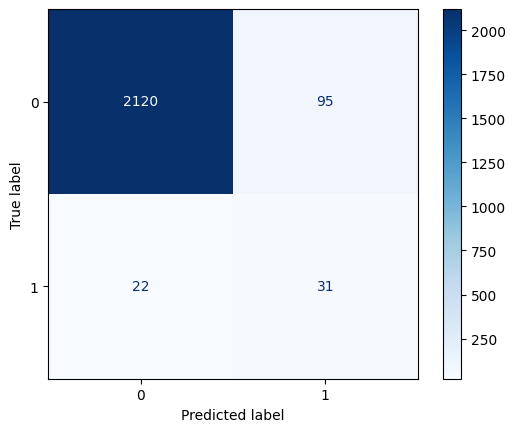

In [62]:
final_table = final_table.sort_values('ANCHOR_CUTOFF').reset_index(drop=True)
print(f"Loaded {final_table.shape[0]} windows for modeling.")
# Identify the categorical columns (those starting with 'mode_' plus other descriptors)
categorical_cols = [col for col in final_table.columns if col.startswith('mode_') or col in [
    'SALES_OFFICE_DESCRIPTION', 
    'SHIPPING_CONDITION_TIME', 
    'scheduled_frequency'
]]

# Perform One-Hot Encoding
modeling_df_encoded = pd.get_dummies(final_table, columns=categorical_cols, dummy_na=False)

# Define X (Features) and y (Target)
# Drop ID columns, date columns, and the target variable itself
X = modeling_df_encoded.drop([
    'CUSTOMER_ID', 
    'ANCHOR_CUTOFF', 
    'NEXT_ANCHOR_CUTOFF', 
    'is_abandoned'
], axis=1)
y = modeling_df_encoded['is_abandoned']
X = X.apply(pd.to_numeric, errors='coerce')

# Impute NaNs with the mean after handling inf values
X = X.replace([np.inf, -np.inf], np.nan)
#X = X.fillna(X.mean())
X = X.fillna(0)
print(f"Number of features (X): {X.shape[1]}")

split_point = int(len(modeling_df_encoded) * 0.8)

X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

print(f"Train size: {len(X_train)} windows")
print(f"Test size: {len(X_test)} windows")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(
        solver='liblinear', 
        class_weight='balanced', a
        random_state=42
    ))
])

#  Train the model
print("\n--- Training Logistic Regression Model ---")
pipeline.fit(X_train, y_train) 

#  Predict on the test set
y_pred = pipeline.predict(X_test) # Uncomment this when 'final_table' is available
y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class (1)

print("\n\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred)) 

print("\n--- ROC-AUC Score ---")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}") 

cm = confusion_matrix(y_test, y_pred) 
print("\n--- CONFUSION MATRIX ---")
print("Predicted:    0 | 1")
print(f"Actual 0: {cm[0, 0]} | {cm[0, 1]}")
print(f"Actual 1: {cm[1, 0]} | {cm[1, 1]}") 

ConfusionMatrixDisplay(cm).plot(cmap=plt.cm.Blues)
plt.show()

In [71]:
import xgboost as xgb

xgboost_model = Pipeline([
    ('scaler', StandardScaler()), 
    ('xgb', xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42,
        n_jobs=-1 
    ))
])

#  Train the model
print("\n--- Training XGBOOST Model ---")
xgboost_model.fit(X_train, y_train) 

#  Predict on the test set
y_pred = xgboost_model.predict(X_test)
y_pred_proba = xgboost_model.predict_proba(X_test)[:, 1] # Probability of the positive class (1)

print("\n\n--- CLASSIFICATION REPORT ---")
print(classification_report(y_test, y_pred)) 

print("\n--- ROC-AUC Score ---")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}") 

cm = confusion_matrix(y_test, y_pred) 
print("\n--- CONFUSION MATRIX ---")
print("Predicted:    0 | 1")
print(f"Actual 0: {cm[0, 0]} | {cm[0, 1]}")
print(f"Actual 1: {cm[1, 0]} | {cm[1, 1]}")


--- Training XGBOOST Model ---


--- CLASSIFICATION REPORT ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2215
           1       1.00      0.91      0.95        53

    accuracy                           1.00      2268
   macro avg       1.00      0.95      0.97      2268
weighted avg       1.00      1.00      1.00      2268


--- ROC-AUC Score ---
ROC-AUC: 0.9847

--- CONFUSION MATRIX ---
Predicted:    0 | 1
Actual 0: 2215 | 0
Actual 1: 5 | 48


C:\python311\Lib\site-packages\xgboost\training.py:199: UserWarning: [23:18:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
